Partie 1: Mécanique céleste

In [29]:
import numpy as np
from astropy.constants import G, M_earth, M_sun 
import matplotlib.pyplot as plt
import de421
from astropy.time import Time
from jplephem import Ephemeris
from numpy import empty, arange, exp, real, imag, pi
from numpy.fft import rfft, irfft, ifft, fft
from math import exp
import cmath
import pandas as pd
from scipy.constants import pi, hbar
# Visual Python: Logic > code
import plotly.express as px
import plotly

a) Implémentation de la méthode de Verlet 

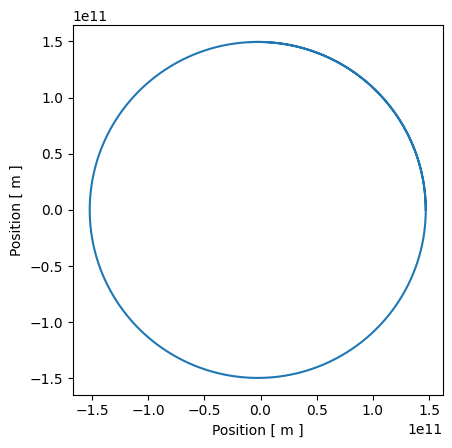

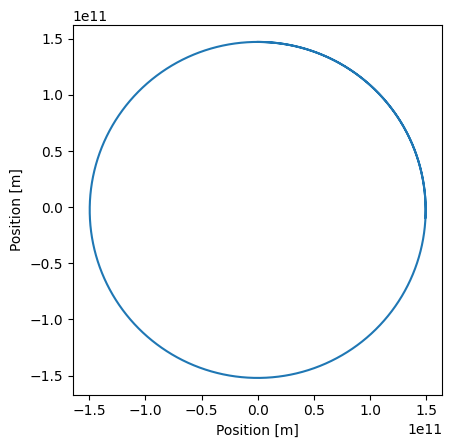

In [30]:
r_0 = 1.4710e11 # m
v_0 = 3.0287e4 #m/s

def f(r):
    return(-G.value * M_sun.value * r/np.linalg.norm(r)**3)
    
def verlet(r, v_1, h, max):
    
    vx=[v_1[0]]
    vy=[v_1[1]]
    x = [r[0]]
    y =[r[1]]
    
    for i in range(1, max):
        r = r + h * v_1
        k = h * f(r)
        v_2 = v_1 + 0.5 * k 
        v_1 = v_1 + k
        vx.append(v_2[0])
        vy.append(v_2[1])
        x.append(r[0])
        y.append(r[1])
             
    
    return(x,y,vx,vy)
    
    #Représentation de différents orbites (les conditions initiales varient)
    
max = 11000 # nombres d'itérations maximales
h = 3600 
r = np.array([r_0, 0])
v_1 =  np.array([0,v_0]) + 0.5 * h * f(r)
x, y, vx, vy = verlet(r, v_1, h, max) # le pas correspond a un incrément temporel de 1h en secondes 
plt.figure()
plt.plot(x, y)
plt.gca().set_aspect("equal")
plt.ylabel("Position [ m ]")
plt.xlabel("Position [ m ]")
plt.show()
    
    
r = np.array([0, r_0])
v_1 =  np.array([v_0,0]) + 0.5 * h * f(r)
xverlet, yverlet, vxverlet,vyverlet = verlet(r, v_1, h, max)
plt.figure()
plt.plot(xverlet, yverlet)
plt.gca().set_aspect("equal")
plt.ylabel("Position [m]")
plt.xlabel("Position [m]")
plt.show()

B) Méthode de Verlet en calculant l'énergie

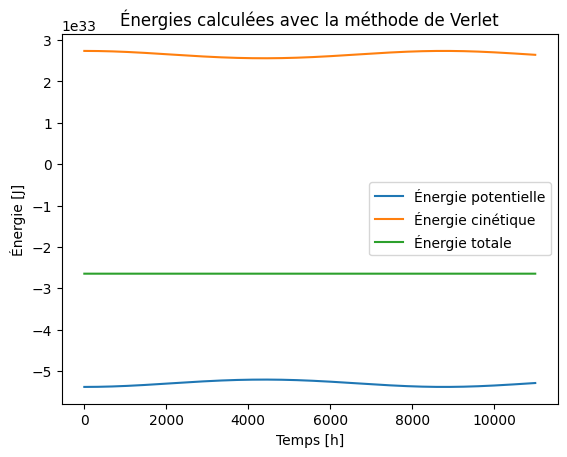

In [31]:
def verletenergie(r, v_1, h, max):
    U = [-G.value*M_sun.value*M_earth.value/np.linalg.norm(r)]
    E_k = [1/2*M_earth.value*np.linalg.norm(v_1)**2]
    E_tot = [U[0]+E_k[0]]
    
    vx=[v_1[0]]
    vy=[v_1[1]]
    x = [r[0]]
    y =[r[1]]
    
    for i in range(1, max):
        r = r + h * v_1
        k = h * f(r)
        v_2 = v_1 + 0.5 * k 
        v_1 = v_1 + k
        vx.append(v_2[0])
        vy.append(v_2[1])
        x.append(r[0])
        y.append(r[1])
    
        E_k.append(1/2*M_earth.value*np.linalg.norm(v_2)**2)
        U.append(-G.value*M_sun.value*M_earth.value/np.linalg.norm(r))
        E_tot.append(U[i] + E_k[i])
    
    return(E_k,U, E_tot)
    
    
    
r = np.array([r_0, 0])
v_1 =  np.array([0,v_0]) + 0.5 * h * f(r)
E_k, U, E_tot = verletenergie(r, v_1, 3600, max)
    
    
plt.figure()
plt.plot(range(max),U, label = "Énergie potentielle")
plt.plot(range(max), E_k, label = "Énergie cinétique")
plt.plot(range(max), E_tot, label = "Énergie totale")
plt.title("Énergies calculées avec la méthode de Verlet")
plt.ylabel("Énergie [J]")
plt.xlabel("Temps [h]")
plt.legend()
plt.show()

Commentaire blah blah blah blah

C) Méthode d'Euler, RK2, RK4

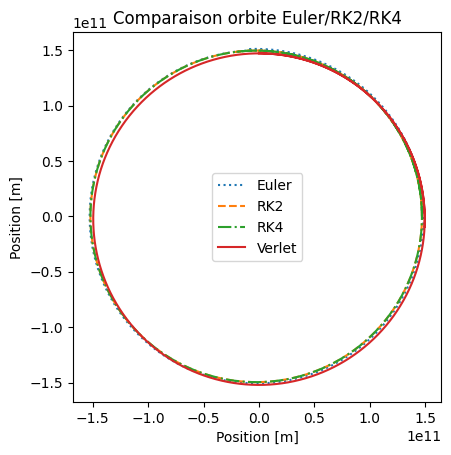

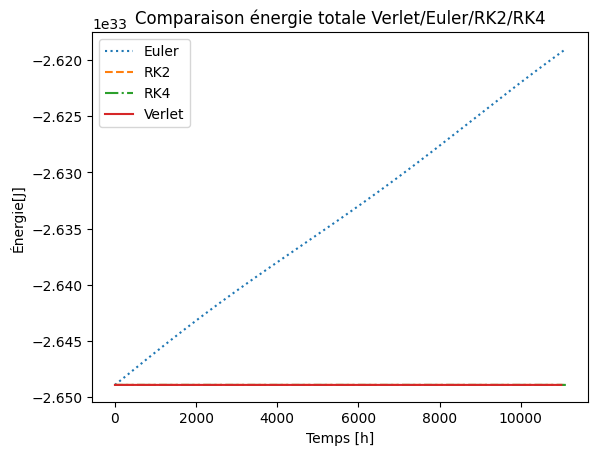

In [37]:


def f2(r):
    x, y, vx, vy = r

    Dx = vx
    Dy = vy

    R = np.sqrt(x**2+y**2)
    Dvx = -G.value*M_sun.value*x/R**3
    Dvy=  - G.value*M_sun.value*y/R**3

    return(np.array([Dx, Dy, Dvx, Dvy]))

def Euler(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    x = []
    y = []
    vx = []
    vy = [] 
    E_tot = []
    r = np.array([r_0, 0, 0, v_0]) 

    j = 0
    for t in tpoints: 
        x.append(r[0])
        y.append(r[1])
        vx.append(r[2])
        vy.append(r[3])
        E_tot.append(-G.value*M_sun.value*M_earth.value/(np.sqrt(x[j]**2+y[j]**2)) + 1/2*M_earth.value*(np.sqrt(vx[j]**2+vy[j]**2))**2)
        r += h * f2(r)
        j +=1

        

    return(tpoints, x, y, vx, vy,  E_tot) 

def RK2(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    x = []
    y = []
    vx = []
    vy = [] 
    E_tot = []
    r = np.array([r_0, 0, 0, v_0]) 

    j = 0
    for t in tpoints: 
        x.append(r[0])
        y.append(r[1])
        vx.append(r[2])
        vy.append(r[3])

        E_tot.append(-G.value*M_sun.value*M_earth.value/(np.sqrt(x[j]**2+y[j]**2)) + 1/2*M_earth.value*(np.sqrt(vx[j]**2+vy[j]**2))**2)
        j += 1
        k1 = h * f2(r)
        k2 = h * f2(r+0.5*k1)
        r += k2

    return(tpoints,x, y, vx, vy,  E_tot)

def RK4(a, b, h, r_0, v_0): 
    tpoints = np.arange(a,b,h)
    x = []
    y = []
    vx = []
    vy = [] 
    E_tot = []
    r = np.array([r_0, 0, 0, v_0]) 

    j = 0
    for t in tpoints: 
        x.append(r[0])
        y.append(r[1])
        vx.append(r[2])
        vy.append(r[3])

        E_tot.append(-G.value*M_sun.value*M_earth.value/(np.sqrt(x[j]**2+y[j]**2)) + 1/2*M_earth.value*(np.sqrt(vx[j]**2+vy[j]**2))**2)
        j += 1
        k1 = h * f2(r)
        k2 = h * f2(r+0.5*k1)
        k3 = h * f2(r+0.5*k2)
        k4 = h*f2(r+k3)
        r += (k1+2*k2+2*k3+k4)/6

    return(tpoints,x, y, vx, vy,  E_tot)


E_k, U, E_totVerlet = verletenergie(r, v_1, 3600, max)
tRK2, xRK2,yRK2, vxRK2, vyRK2, ERK2 = RK2(0, 40000000, 3600, r_0, v_0)
tRK4, xRK4,yRK4, vxRK4, vyRK4, ERK4 = RK4(0, 40000000, 3600, r_0, v_0)
tEuler, xEuler,yEuler, vxEuler,vyEuler, EEuler = Euler(0, 40000000, 3600, r_0, v_0)
temps = [x/3600 for x in tRK4]

plt.figure()
plt.title("Comparaison orbite Euler/RK2/RK4")
plt.ylabel("Position [m]")
plt.xlabel("Position [m]")
plt.plot(xEuler,yEuler, label = "Euler", linestyle = "dotted")
plt.plot(xRK2,yRK2, label = "RK2", linestyle = "dashed")
plt.plot(xRK4,yRK4, label = "RK4", linestyle = "dashdot")
plt.plot(xverlet, yverlet, label="Verlet")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()


plt.figure()
plt.title("Comparaison énergie totale Verlet/Euler/RK2/RK4")
plt.ylabel("Énergie[J]")
plt.xlabel("Temps [h]")
plt.plot(temps,EEuler, label = "Euler", linestyle = "dotted")
plt.plot(temps,ERK2, label = "RK2", linestyle = "dashed")
plt.plot(temps,ERK4, label = "RK4", linestyle = "dashdot")
plt.plot(range(max),E_totVerlet, label = "Verlet")
plt.legend()
plt.show()

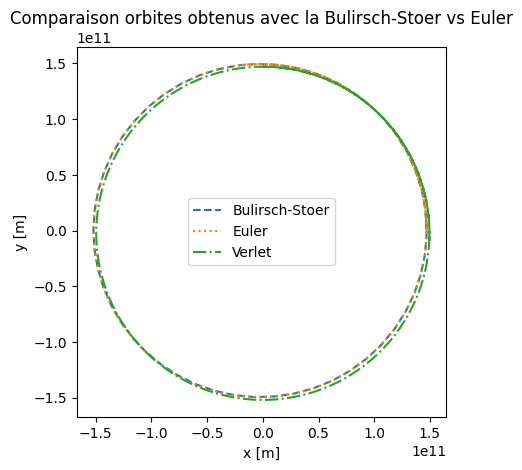

In [19]:
#d) Bulirsch-Stoer
def f(x, y):
    return(-G.value * M_sun.value * x/((x**2+y**2)**0.5)**3, -G.value * M_sun.value * y/((x**2+y**2)**0.5)**3)
    
def g(rx, ry):
    x = rx[0]
    vx = rx[1]
    y = ry[0]
    vy = ry[1]
    fx=vx
    fvx=f(x, y)[0]
    fy=vy
    fvy=f(x, y)[1]
    return np.array([fx, fvx, fy, fvy],float)

def Bulirsch(a, b, H, r_0, v_0, delta):
    tpoints = np.arange(a, b, H)
    x = []
    y = []
    rx = np.array([r_0, 0.0], float)
    ry = np.array([0, v_0], float)
    
    for t in tpoints:
        x.append(rx[0])
        y.append(ry[0])
        vx.append(rx[1])
        vy.append(ry[1])
        n = 1

        r1x = rx + 0.5*H*g(rx, ry)[0:2]
        r1y = ry + 0.5*H*g(rx, ry)[2:4]
        r2x = rx + H*g(r1x, r1y)[0:2]
        r2y = ry + H*g(r1x, r1y)[2:4]

        R1x = np.empty([1,2],float)
        R1x[0] = 0.5*(r1x+r2x+0.5*H*g(r2x, r2y)[0:2])




        R1y = np.empty([1,2],float)
        R1y[0] = 0.5*(r1y+r2y+0.5*H*g(r2x, r2y)[2:4])
    
        errorx = errory = 2*H*delta
        while errorx > H*delta and errory > H*delta:
            n += 1
            h = H/n
    
            r1x = rx + 0.5*h*g(rx, ry)[0:2]
            r1y = ry + 0.5*h*g(rx, ry)[2:4]
            r2x = rx + h*g(r1x, r1y)[0:2]
            r2y = ry + h*g(r1x,r1y)[2:4]
    
            for i in range(n-1):
                r1x += h*g(r2x, r2y)[0:2]
                r1y += h*g(r2x ,r2y)[2:4]
                r2x += h*g(r1x, r1y)[0:2]
                r2y += h*g(r1x ,r1y)[2:4]
    
            R2x = R1x
            R2y = R1y
    
            R1x = np.empty([n,2], float)
            R1x[0] = 0.5*(r1x+r2x+0.5*h*g(r2x, r2y)[0:2])
            R1y = np.empty([n,2], float)
            R1y[0] = 0.5*(r1y+r2y+0.5*h*g(r2x ,r2y)[2:4])
    
            for m in range (1, n):
                epsilonx = (R1x[m-1]-R2x[m-1])/((n/(n-1))**(2*m)-1)
                R1x[m] = R1x[m-1] + epsilonx
                epsilony = (R1y[m-1]-R2y[m-1])/((n/(n-1))**(2*m)-1)
                R1y[m] = R1y[m-1] + epsilony
            errorx = abs(epsilonx[0])
            errory = abs(epsilony[0])
    
        rx = R1x[n-1]
        ry = R1y[n-1]                    
    return(x,y,vx, vy, tpoints)
    
r_0 = 1.4710e11 # m
v_0 = 3.0287e4 #m/s
    
xBur, yBur,vxbur, vybur, tBur = Bulirsch(0, 32500000, 3600*24*7, r_0, v_0, 1000/(365*24*3600))

plt.title("Comparaison orbites obtenus avec la Bulirsch-Stoer vs Euler")
plt.plot(xBur, yBur, label = "Bulirsch-Stoer", linestyle="dashed")
plt.plot(xEuler, yEuler, label="Euler", linestyle="dotted")
plt.plot(xverlet, yverlet, label="Verlet", linestyle="dashdot")
plt.gca().set_aspect("equal")
plt.ylabel("y [m]")
plt.xlabel("x [m]")
plt.legend()
plt.show()

e) Bulirsch-Stoer en 3D pour trouver l'orbite de mars 

C:\Users\gaelm\AppData\Local\Temp\ipykernel_10468\2129300044.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_0x = float(position[0]*1000)
C:\Users\gaelm\AppData\Local\Temp\ipykernel_10468\2129300044.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_0x = float(velocity[0]/86.4)
C:\Users\gaelm\AppData\Local\Temp\ipykernel_10468\2129300044.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_0y = float(position[1]*1000)
C:\Users\gaelm\AppData\Local\Temp\

position théorique = [2.35763766e+11] m
position calculé = 232784877894.36557 m
différence: 2 %


C:\Users\gaelm\AppData\Local\Temp\ipykernel_10468\2129300044.py:141: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"différence: {100 - int(position_bulirsch/position_fin*100)} %")


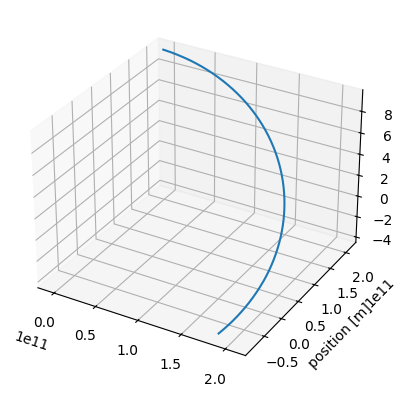

In [13]:
eph = Ephemeris(de421)

# dates,
lancement=Time("2020-07-30")
atterissage=Time("2021-02-18")

# un nombre de jours juliens est attendu par la routine, d’o`u le .jd,
# position en km, vitesse en km par jour,
position, velocity = eph.position_and_velocity('mars',lancement.jd)



r_0x = float(position[0]*1000)
v_0x = float(velocity[0]/86.4)

r_0y = float(position[1]*1000)
v_0y = float(velocity[1]/86.4)

r_0z = float(position[2]*1000)
v_0z = float(velocity[2]/86.4)

#modification de l'équation f(x) en 3D
def f(x, y, z):
    return(-G.value * M_sun.value * x/((x**2+y**2+z**2)**0.5)**3, -G.value * M_sun.value * y/((x**2+y**2+z**2)**0.5)**3, -G.value * M_sun.value * z/((x**2+y**2+z**2)**0.5)**3)


# Implémentation de la méthode de Bulirsch-Stoer en 3D  
def g(rx, ry, rz):
    x = rx[0]
    vx = rx[1]
    y = ry[0]
    vy = ry[1]
    z = rz[0]
    vz = rz[1]
    fx=vx
    fvx=f(x, y, z)[0]
    fy=vy
    fvy=f(x, y, z)[1]
    fz=vz
    fvz=f(x, y, z)[2]
    return np.array([fx, fvx, fy, fvy, fz, fvz],float)

def Bulirsch3D(a, b, H, r_0x, v_0x, r_0y, v_0y, r_0z, v_0z, delta):
    tpoints = np.arange(a, b, H)
    x = []
    y = []
    z = []
    vz = []
    rx = np.array([r_0x, v_0x], float)
    ry = np.array([r_0y, v_0y], float)
    rz = np.array([r_0z, v_0z], float) 
    
    for t in tpoints:
        x.append(rx[0])
        y.append(ry[0])
        z.append(rz[0])
        vx.append(rx[1])
        vy.append(ry[1])
        vz.append(rz[1])
        n = 1

        r1x = rx + 0.5*H*g(rx, ry, rz)[0:2]
        r1y = ry + 0.5*H*g(rx, ry, rz)[2:4]
        r1z = rz + 0.5*H*g(rx, ry, rz)[4:6]
        r2x = rx + H*g(r1x, r1y, r1z)[0:2]
        r2y = ry + H*g(r1x, r1y, r1z)[2:4]
        r2z = rz + H*g(r1x, r1y, r1z)[4:6]

        R1x = np.empty([1,2],float)
        R1x[0] = 0.5*(r1x+r2x+0.5*H*g(r2x, r2y, r2z)[0:2])




        R1y = np.empty([1,2],float)
        R1y[0] = 0.5*(r1y+r2y+0.5*H*g(r2x, r2y, r2z)[2:4])

        R1z = np.empty([1,2],float)
        R1z[0] = 0.5*(r1z+r2z+0.5*H*g(r2x, r2y, r2z)[2:4])
    
        errorx = errory = errorz = 2*H*delta
        while errorx > H*delta and errory > H*delta and errorz > H*delta:
            n += 1
            h = H/n
    
            r1x = rx + 0.5*h*g(rx, ry, rz)[0:2]
            r1y = ry + 0.5*h*g(rx, ry, rz)[2:4]
            r1z = rz + 0.5*h*g(rx, ry, rz)[4:6]
            r2x = rx + h*g(r1x,r1y,r1z)[0:2]
            r2y = ry + h*g(r1x,r1y,r1z)[2:4]
            r2z = rz + h*g(r1x,r1y,r1z)[4:6]
    
            for i in range(n-1):
                r1x += h*g(r2x, r2y, r2z)[0:2]
                r1y += h*g(r2x ,r2y, r2z)[2:4]
                r1z += h*g(r2x ,r2y, r2z)[4:6]
                r2x += h*g(r1x, r1y, r2z)[0:2]
                r2y += h*g(r1x ,r1y, r2z)[2:4]
                r2z += h*g(r1x ,r1y, r2z)[4:6]
    
            R2x = R1x
            R2y = R1y
            R2z = R1z
    
            R1x = np.empty([n,2], float)
            R1x[0] = 0.5*(r1x+r2x+0.5*h*g(r2x, r2y, r2z)[0:2])
            R1y = np.empty([n,2], float)
            R1y[0] = 0.5*(r1y+r2y+0.5*h*g(r2x ,r2y, r2z)[2:4])
            R1z = np.empty([n,2], float)
            R1z[0] = 0.5*(r1z+r2z+0.5*h*g(r2x ,r2y, r2z)[4:6])
    
            for m in range (1, n):
                epsilonx = (R1x[m-1]-R2x[m-1])/((n/(n-1))**(2*m)-1)
                R1x[m] = R1x[m-1] + epsilonx
                epsilony = (R1y[m-1]-R2y[m-1])/((n/(n-1))**(2*m)-1)
                R1y[m] = R1y[m-1] + epsilony
                epsilonz = (R1z[m-1]-R2z[m-1])/((n/(n-1))**(2*m)-1)
                R1z[m] = R1z[m-1] + epsilonz
            errorx = abs(epsilonx[0])
            errory = abs(epsilony[0])
            errorz = abs(epsilonz[0])
    
        rx = R1x[n-1]
        ry = R1y[n-1]     
        rz = R1z[n-1]                
    return(x,y,z,vx,vy,vz, tpoints)

xBur, yBur, zBur, vxbur, vybur, vzbur, tBur = Bulirsch3D(0, 203*24*60*60, 30000, r_0x, v_0x, r_0y, v_0y, r_0z, v_0z, 900/(365*24*3600))


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(xBur, yBur, zBur)

position_fin = eph.position('mars',atterissage.jd)
position_fin = (((position_fin[0]**2)+(position_fin[1]**2)+(position_fin[2]**2))**0.5)*1000
print(f"position théorique = {position_fin} m")
position_bulirsch = (xBur[-1]**2+yBur[-1]**2+zBur[-1]**2)**0.5
print(f"position calculé = {position_bulirsch} m")
print(f"différence: {100 - int(position_bulirsch/position_fin*100)} %")

Partie 3: L'équation de Schrödinger et la méthode spectrale

h)

In [ ]:
#1D DST Type-1 : discrete sinus Fourier transform 
def dst(y):       #Prends les valeurs réelles uniquement
    N = len(y)   #nombre de sections sur la dimension de longueur L: N = 1000
    y2 = empty(2*N, float)   #matrice vide de format 2*N et de type float
    y2[0]=y2[N] = 0.0    #Les extémités sont nulles
    y2[1:N] = y[1:]    
    y2[:N:-1] = -y[1:]     #organiser la symétrie de y2 basée sur y
    a = -imag(rfft(y2))[:N]    #Donne la valeur imaginaire de l'argument *-1
    a[0] = 0.0
    return a

def dst_rfft(y):    #Prends les valeurs réelles uniquement
    N = len(y)  
    y2 = empty(2*N, float)   
    y2[0]=y2[N] = 0.0    
    y2[1:N] = y[1:]    
    y2[:N:-1] = -y[1:]    
    R = rfft(y2)[:N].real   
    I = imag(rfft(y2))[:N]
    complet = rfft(y2)[:N]
    R[0] = 0.0
    I[0] = 0.0
    return R,I, complet

def dst_toute(y):   #Prends les valeurs réelles et imaginaire de l'espace normal
    N = len(y)   
    y2 = empty(2*N, float)   
    y2[0]=y2[N] = 0.0    
    y2[1:N] = y[1:]    
    y2[:N:-1] = -y[1:]     
    a = fft(y2)[:N]    
    a[0] = 0.0
    return a

#Constantes données
N = 1000
L = 10**(-8)
M = 9.109*10**(-31)

#Créer la matrice des valeurs de psi(x,0)
psi = np.zeros(N, dtype='complex_')

def psi0(x):  
    x0 = L/2
    xn = L/N
    sig = 10**(-10)
    kappa = 5*10**10
    X = (np.exp(-((x*xn-x0)**2)/(2*sig**2)))*(cmath.exp(1j*kappa*x*xn))
    return X 

x = np.arange(0,N,1)


for i in x:
    psi[i] = psi0(i)    #psi est une matrice de nombres complexe


R, I, complet = dst_rfft(psi)
R = np.expand_dims(R, axis=1)
I = np.expand_dims(I, axis=1)
bk = np.concatenate((R,I), axis=1)


fft = dst_toute(psi)
# print(fft[1])
# print(fft.real[1])
# print(fft.imag[1])
# plt.plot(x[:300], fft.imag[:300])
# plt.plot(x[:300], I[:300])
# plt.title('Parties imaginaires comparées')
# plt.savefig('/home/alicecalice/Documents/Physique numérique/TP3/les2I')
# plt.show()

# plt.plot(x, np.exp(-((x*xn-x0)**2)/(2*sig**2)))*(cmath.exp(1j*kappa*x*xn))
# plt.plot(x, R)
# plt.title('Partie réelle en fonction de k')
# plt.savefig('/home/alicecalice/Documents/Physique numérique/TP3/R')
# plt.show()
# plt.plot(x[:300], I[:300])
# plt.title('Partie imaginaire en fonction de k')
# plt.savefig('/home/alicecalice/Documents/Physique numérique/TP3/I_crop')
# plt.show()




i) La documentation de numpy.fft.rfft infique
''When the DFT is computed for purely real input, the output is Hermitian-symmetric, i.e. the negative frequency terms are just the complex conjugates of the corresponding positive-frequency terms, and the negative-frequency terms are therefore redundant. This function does not compute the negative frequency terms, and the length of the transformed axis of the output is therefore n//2 + 1.'' (https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html)

Newman indique  que ''a discrete cosine transform is nothing more than an ordinary discrete Fourier transform performed on a set of samples that are symmetric around the middle of the transform interval.'' (p.318). 

La fonction donnée à la transformée de Fourier rapide de valeurs réelles contient des valeurs imaginaires. Par contre, comme cette fonction est un sinus, elle présente une symétrie, qu'on peut centrer autour du centre de l'interval de la transformée de Fourier. Les valeurs réelles peuvent présenter à elles seules l'aspect symétrique de la fonction. Pour l'imaginer, on peut visualiser la fonction qui sinusoïdale qui évolue autour du cercle trigonométrique. 
 

j)

In [ ]:

# def idsti(a):
#     N = len(a)
#     c = empty(N+1, dtype='complex_')
#     c[0] = c[N] = 0.0
#     c[1:N] = -1j*a[1:]
#     y = ifft(c)[:N]
#     y[0] = 0.0
#     return y

def idst(a):
    N = len(a)
    c = empty(N+1, dtype='complex_')
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0
    return y

psi_xn_rfft = idst(complet)
psi_xn_fft = idst(fft)


# plt.plot(x[400:600], R[400:600], label='rfft')
# plt.plot(x[400:600], fft[400:600], label='fft')

# plt.plot(x[400:600], psi_xn_rfft[400:600], label='rfft')
# plt.plot(x[400:600], psi_xn_fft[400:600], label='fft')
# plt.title('idst de b_k obtenus avec rfft et fft')
# plt.legend()
# plt.savefig('/home/alicecalice/Documents/Physique numérique/TP3/les2idst')
# plt.show()

t = 1e-16
cte = (pi**2)*hbar*t/2/M/L**2
#PLOTER L'ÉQUATION 12
# psi12 = np.zeros(N)
# for i in x:
#     psi12[i] = (np.exp(-((i*L/N - L/2)**2)/(2*sig**2)))*cmath.exp(1j*kappa*i)
# plt.plot(x[400:600], psi12[400:600])
# plt.title(r'Équation 12: $\psi(x,0) = exp[-\frac{x-x_0}{2\sigma^2}]e^{i\kappa x}$')
# plt.savefig('/home/alicecalice/Documents/Physique numérique/TP3/eq12')
# plt.show()


#PLOTER L'ÉQUATION 11
# psi11 = np.zeros(N)
# for n in range(N):
#     S11 = 0
#     for K in range(N):
#         k = K+1
#         bk = complet[K]
#         S11 += bk*(np.sin(pi*k*n/N))*np.exp(cte*1j*t)
#     psi11[n] = S11/N
# plt.plot(x, psi11)
# plt.title(r'Équation 11: $\psi(x_n,t=10^{-16}) = \frac{1}{N}\sum_{k=1}^{N-1}b_k\sin(\frac{\pi k n}{N})exp(i\frac{\pi^2\hbar k^2}{2ML^2}t)$')
# # plt.savefig('/home/alicecalice/Documents/Physique numérique/TP3/eq11')
# plt.show()


#PLOTER L'ÉQUATION 14
def eq14(t):
    repsi = np.zeros(N)
    cte = (pi**2)*hbar*t/2/M/L**2
    for n in range(N):
        S = 0
        for K in range(N):
            k = K+1
            s1 = R[K]*np.cos(cte*k**2)
            s2 = -I[K]*np.sin(cte*k**2)
            s3 = np.sin(pi*k*n/N)
            S += (s1-s2)*s3
        repsi[n] = S/N
    return repsi

T = 10
time = [i*1e-18 for i in range(T)]
t_list = []
x_list = []
value_list = []
for t in time:
    cte = (pi**2)*hbar*t/2/M/L**2
    for n in range(N):
        S = 0
        for K in range(N):
            k = K+1
            s1 = R[K]*np.cos(cte*k**2)
            s2 = -I[K]*np.sin(cte*k**2)
            s3 = np.sin(pi*k*n/N)
            S += (s1-s2)*s3
        t_list.append(t)
        x_list.append(n)
        value_list.append((S/N)[0])

# plt.plot(x, repsi)
# plt.title(r'Équation 14: $Re\psi(x_n, t=10^{-16}) = \frac{1}{N}\sum_{k=1}^{N-1}[\alpha_k\cos(\frac{\pi^2\hbar k^2}{2ML^2}t) - \eta_k\sin(\frac{\pi^2\hbar k^2}{2ML^2}t)]\sin(\frac{\pi k n}{N})$')
# # plt.savefig('/home/alicecalice/Documents/Physique numérique/TP3/eq14')
# plt.show()

# plt.plot(x, psi_xn)
# plt.show()

In [ ]:
dict = {'Time':t_list, 'x':x_list, 'value':value_list}
df = pd.DataFrame(dict)

print(df)


In [ ]:
plotly.offline.init_notebook_mode(connected=True)
fig = px.line(df, x='x', y='value', animation_frame='Time', range_y=[-1,1])
fig.show()